## 6) Apply perspective transform to thresholded binary image

../test_images/test1.jpg


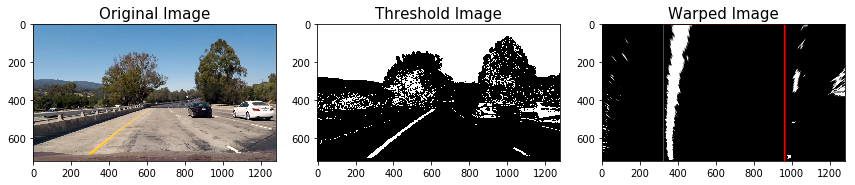

../test_images/test2.jpg


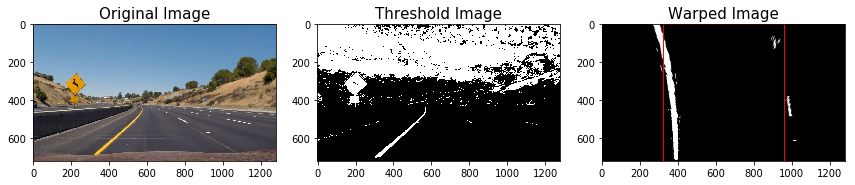

../test_images/test3.jpg


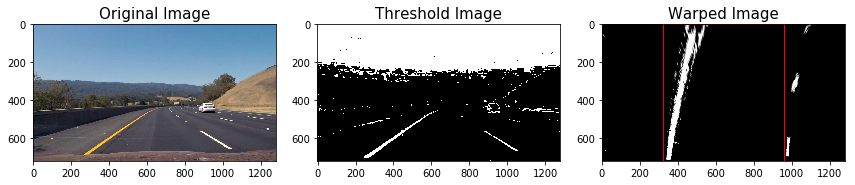

../test_images/test4.jpg


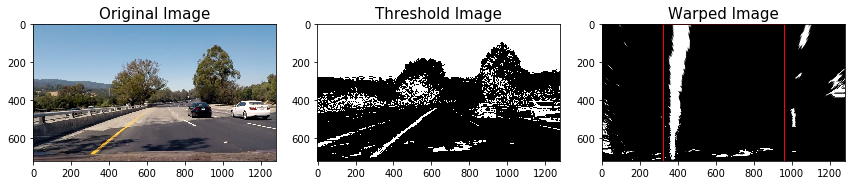

../test_images/test5.jpg


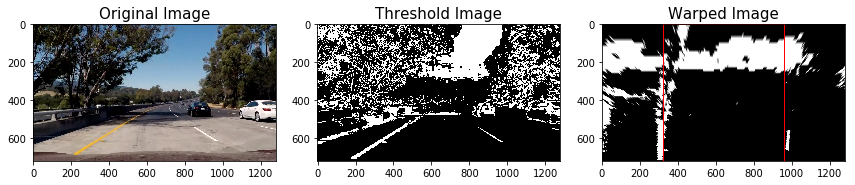

../test_images/test6.jpg


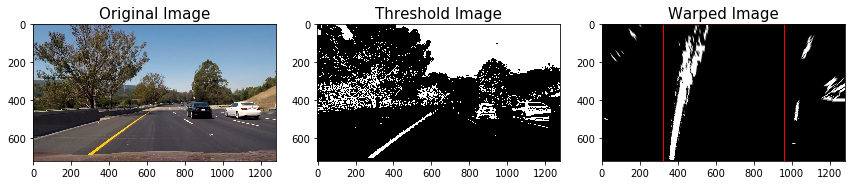

In [2]:
%run 'imports.py'
%run 'testbed_misc.py'

images = glob.glob('../test_images/test*.jpg')
im_images = list()
th_images = list()
for fname in images:
    print(fname)
    
    img = mpimg.imread(fname)
    img_undist = cal_undistort(img)
    threshold_img = threshold_pipeline(img_undist, Settings.thresholds, ksize=23, debug=False)
    img_warp, _, _ = warp_image(threshold_img)
    im_images.append(img)
    th_images.append(img_warp)

    _, _, ax3 = visualize_images(img, threshold_img, img_warp)
    ax3.add_patch(patches.Polygon(xy=[Settings.dst[0],Settings.dst[1],\
                                      Settings.dst[3],Settings.dst[2]], fill=False, edgecolor='r'))
    
    plt.show()


## 7a) Detect lane pixels and fit to find the lane boundary. (sliding window)

(720, 1280)
(1280,)


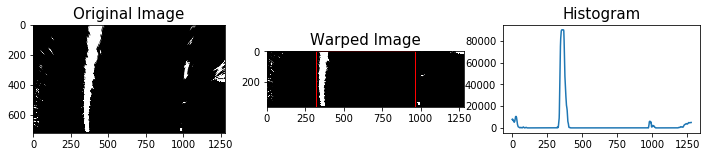

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import gridspec

binary_warped = np.asarray(th_images[0])
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
histogram = histogram
print(binary_warped.shape)
print(histogram.shape)


#plt.plot(histogram)

f = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(3, 3, width_ratios=[4, 4, 4], height_ratios=[4, 4, 8])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

#ax1.imshow(im_images[0])
ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Original Image', fontsize=15)#binary_warped[:binary_warped.shape[0]//2,:]
ax2.imshow(binary_warped[binary_warped.shape[0]//2:,:], cmap='gray')
#ax2.imshow(th_images[0], cmap='gray')
ax2.set_title('Warped Image', fontsize=15)
# Draw Polygon Lines
ax2.add_patch(patches.Polygon(xy=[Settings.dst[0],Settings.dst[1],Settings.dst[3],\
                                  Settings.dst[2]], fill=False, edgecolor='r'))

f = plt.figure(figsize=(12, 9))
ax3.plot(histogram)
ax3.set_title('Histogram', fontsize=15)



plt.show()

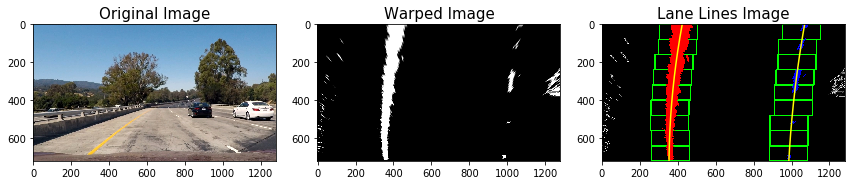

In [6]:
%run 'imports.py'
%run 'testbed_misc.py'

img_idx = 0
binary_warped = np.asarray(th_images[img_idx])
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
out_img = out_img.astype(np.uint8)

midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

nwindows = 9
window_height = np.int(binary_warped.shape[0]//nwindows)

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_current = leftx_base
rightx_current = rightx_base

margin = 100
minpix = 50

left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 6) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 6) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
# left_lane_inds == all the good left inds
left_lane_inds = np.concatenate(left_lane_inds)
# right_lane_inds == all the good right inds
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# VISUALIZE
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#'''

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 9))
#f.subplots_adjust(hspace=0.3)
f.tight_layout()
ax1.imshow(im_images[img_idx])
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=15)
ax3.imshow(out_img, cmap='gray')
ax3.set_title('Lane Lines Image', fontsize=15)
ax3.plot(left_fitx, ploty, color='yellow')
ax3.plot(right_fitx, ploty, color='yellow')

plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()


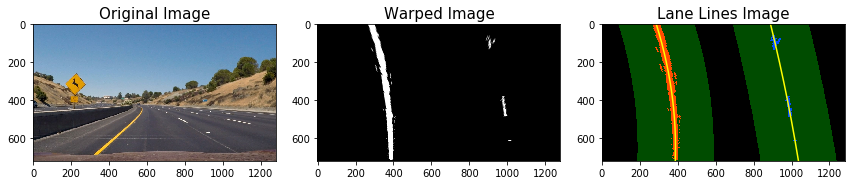

In [7]:

img_idx = 1
binary_warped = np.asarray(th_images[img_idx])
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 200
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                  (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                   (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]





# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
out_img = out_img.astype(np.uint8)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 9))
#f.subplots_adjust(hspace=0.3)
f.tight_layout()
ax1.imshow(im_images[img_idx])
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=15)
ax3.imshow(result, cmap='gray')
ax3.set_title('Lane Lines Image', fontsize=15)
ax3.plot(left_fitx, ploty, color='yellow')
ax3.plot(right_fitx, ploty, color='yellow')

plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()


## 7b) Detect lane pixels. (convolution)

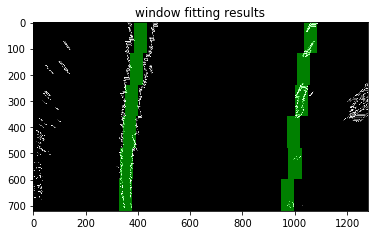

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
#warped = mpimg.imread('warped_example.jpg')
img_idx = 0
warped = np.asarray(th_images[img_idx])
# window settings
window_width = 50 
window_height = 120 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows    
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    warpage = warpage.astype(np.uint8)
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

else: 
# If no window centers found, just display orginal road image
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


## 8a) Warp the detected lane boundaries back onto the original image.

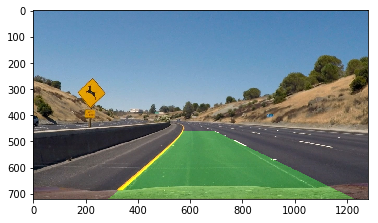

In [11]:

img_idx = 1
warped = np.asarray(th_images[img_idx])

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))



warp_transform = pickle.load( open( "warp_transform.p", "rb" ) )
M = warp_transform["M"]
Minv = warp_transform["Minv"]



# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(im_images[img_idx], 1, newwarp, 0.3, 0)
plt.imshow(result)

plt.show()